# Create dataset
Pipeline that contains the code to process dataset creating a folder structure based on bee classes.

## Architecture
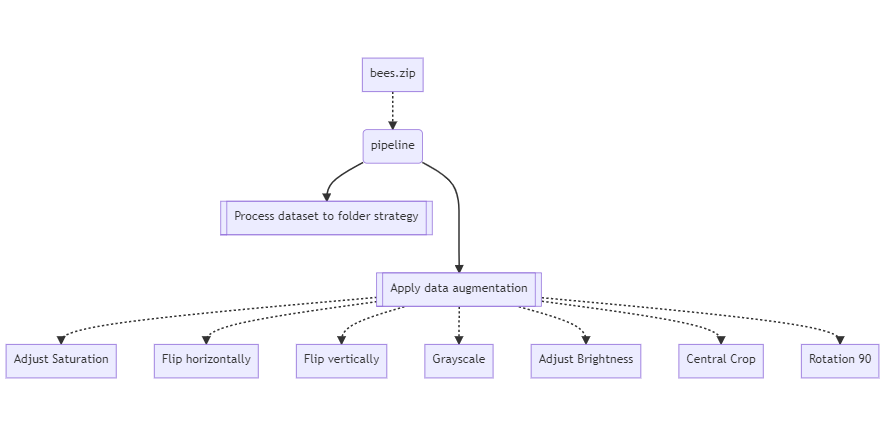

# Prepare dataset from Google Drive

Dataset format:

- specie_group_1
    - specie_subgroup_1_1
    - specie_subgroup_1_2
    - specie_subgroup_1_3
- specie_group_2
    - specie_subgroup_2_1
    - specie_subgroup_2_2
    - specie_subgroup_2_3
- specie_group_n
    - specie_subgroup_n_1
    - specie_subgroup_n_2
    - specie_subgroup_n_n

This format with this notebook should be converted to:

```
- dataset_root
    - specie_1
    - specie_2
    - specie_3
    - specie_4
    - specie_5
    - ...
    - specie_n
```

Cleaning temporary directories

In [ ]:
%rm -rf './sample_data' 'dataset' 'execution-logs' 'dataset.processed' 'augmented-dataset.zip' './dataset-splitted'

Defining the global constants

In [ ]:
class Constants(object):
  DRIVE_MOUNT_PATH = './gdrive'
  DRIVE_PATH = f'{DRIVE_MOUNT_PATH}/My Drive/Colab Notebooks'
  DRIVE_DATASET_PATH = f'{DRIVE_PATH}/dataset-processed'
  ZIP_DATASET_DRIVE_PATH = f'{DRIVE_PATH}/bees.zip'
  DATASET_PATH = './dataset'
  AUGMENTED_DATASET_FILENAME = './augmented-dataset'
  DRIVE_AUGMENTED_DATASET_PATH = f'{DRIVE_PATH}/augmented-dataset.zip'
  DATASET_PROCESSING_IDENTIFICATION_FILE_PATH = './dataset.processed'
  SPECIE_NAME_IDENTIFIER_FILE_EXTENSION = '.tps'
  FILE_EXTENSION_ELIGIBLE_TO_REMOVE = ('.png', '.npy', '.db', '.txt', '.bmp')
  DATASET_SPLITTED_PATH = './dataset-splitted'
  TRAIN_DATASET_PATH = f'{DATASET_SPLITTED_PATH}/train'

Importing dependencies

In [ ]:
from google.colab import drive
from zipfile import ZipFile
from posixpath import split
from glob import glob
from uuid import uuid4
from tqdm import tqdm
import tensorflow as tf
import shutil
import os
import re

Mounting Google Drive in the directory system on this machine

In [ ]:
drive.mount(Constants.DRIVE_MOUNT_PATH, force_remount=True, timeout_ms=60000)

Downloading from Google Drive the dataset to current path

In [ ]:
zip_ref = ZipFile(Constants.ZIP_DATASET_DRIVE_PATH, 'r')
zip_ref.extractall(Constants.DATASET_PATH)
zip_ref.close()

Define functions for processing dataset

In [ ]:
def remove_unused_file_from_dataset(root, file):
  os.unlink(os.path.join(root, file))

def remove_unused_directory_from_dataset(root, directory):
  if os.path.exists(os.path.join(root, directory)):
    shutil.rmtree(os.path.join(root, directory))

def get_specie_name(file):
  specie_name = file.split('.')[0]
  if '_' in file:
    specie_name = [x.capitalize() for x in specie_name.split('_')]
    specie_name = '_'.join(specie_name)
  specie_name = re.findall('[A-Z][a-z]*', specie_name)
  return '_'.join(specie_name).lower()

def rename_directory_to_specie_name(root, file):
  head, _ = os.path.split(root)
  remove_unused_file_from_dataset(root, file)
  os.rename(root, os.path.join(head, get_specie_name(file)))

def flatten_dataset_directory():
  # Move specie image directories to root
  for dir_path in glob(f'{Constants.DATASET_PATH}/*/*', recursive = True):
    shutil.move(dir_path, Constants.DATASET_PATH)

  # Remove unused directories from root
  for dir_path in glob(f'{Constants.DATASET_PATH}/*', recursive = True):
    dir_name = os.path.basename(dir_path)
    if len(dir_name) == 1:
      remove_unused_directory_from_dataset(Constants.DATASET_PATH, dir_name)

  with open(Constants.DATASET_PROCESSING_IDENTIFICATION_FILE_PATH, 'a') as file:
    file.write('processed')

def remove_unused_items_from_dataset():
  for root, dirs, files in os.walk(Constants.DATASET_PATH):
    for file in files:
      if dirs:
        [remove_unused_directory_from_dataset(root, x) for x in dirs]
      if file.endswith(Constants.FILE_EXTENSION_ELIGIBLE_TO_REMOVE):
        remove_unused_file_from_dataset(root, file)

def rename_folders_from_dataset_to_respectively_specie_name():
  for root, _, files in os.walk(Constants.DATASET_PATH):
    for file in files:
      if file.endswith(Constants.SPECIE_NAME_IDENTIFIER_FILE_EXTENSION):
        rename_directory_to_specie_name(root, file)

Process dataset organizing all images in directories named with its respectively *species*

In [ ]:
def is_dataset_processed():
  return os.path.exists(Constants.DATASET_PROCESSING_IDENTIFICATION_FILE_PATH)

def process_dataset():
  if not is_dataset_processed():
    remove_unused_items_from_dataset()
    rename_folders_from_dataset_to_respectively_specie_name()
    flatten_dataset_directory()

process_dataset()

Split dataset in Train, Val and Test sets
- train set: Training set containing **60%** of all images
- validation set: Training set containing **20%** of all images
- test set: Training set containing **20%** of all images

In [ ]:
!pip install split-folders
import splitfolders

splitfolders.ratio(Constants.DATASET_PATH, 
                   output=Constants.DATASET_SPLITTED_PATH, 
                   seed=1337, 
                   ratio=(0.6, 0.2, 0.2))

Show split sizes

In [ ]:
def show_image_size_in_set_folders():
  print(len(list(glob(f'{Constants.TRAIN_DATASET_PATH}/**/*.jpg'))), 'training images')
  print(len(list(glob(f'{Constants.DATASET_SPLITTED_PATH}/val/**/*.jpg'))), 'validation images')
  print(len(list(glob(f'{Constants.DATASET_SPLITTED_PATH}/test/**/*.jpg'))), 'test images')

show_image_size_in_set_folders()

# Data Augmentation

Data augmentation aims to increase the original dataset modifying the original images applying algorithms to change a image to create others from it.

Methods applied on this notebook:

- Adjust Saturation
  - Saturation factor = 4
- Flip horizontally
- Flip vertically
- Grayscale
- Adjust Brightness
  - delta = 0.2
- Central Crop
  - Central fraction=0.5
- Rotation 90°

Applying these augmentation methods the datase increase in `7 times`.

In [ ]:
def get_new_image_path(image_path):
  basename = os.path.basename(image_path)
  image_name = basename.split('.', 1)[0]
  image_name = f'{image_name}_{str(uuid4()).replace("-", "")}.jpg'
  image_name = image_name.replace(" ", "_")
  return os.path.join(os.path.dirname(image_path), image_name)

def get_decoded_image(image_path):
  image = tf.io.read_file(image_path)
  return tf.io.decode_jpeg(image, channels=3)

def augmentation(original_image):
  images = list()
  # Adjust Saturation
  saturated = tf.image.adjust_saturation(original_image, saturation_factor=4)
  images.append(saturated)
  # Flip horizontally
  flipped_left_right = tf.image.flip_left_right(original_image)
  images.append(flipped_left_right)
  # Flip vertically
  flipped_up_down = tf.image.flip_up_down(original_image)
  images.append(flipped_up_down)
  # Grayscale
  grayscaled = tf.image.rgb_to_grayscale(original_image)
  images.append(grayscaled)
  # Adjust Brightness
  bright = tf.image.adjust_brightness(original_image, delta=0.2)
  images.append(bright)
  # Central Crop
  cropped = tf.image.central_crop(original_image, central_fraction=0.5)
  images.append(cropped)
  # Rotation 90
  rotated = tf.image.rot90(original_image)
  images.append(rotated)
  return images

def save_image(image_path, image):
  image_dest_path = get_new_image_path(image_path)
  tf.keras.utils.save_img(image_dest_path, image)

def augment_the_dataset():
  for image_path in tqdm(glob(f'{Constants.TRAIN_DATASET_PATH}/**/*.jpg')):
    image_decoded = get_decoded_image(image_path)
    images = augmentation(image_decoded)
    for image in images:
      save_image(image_path, image)
    del images

augment_the_dataset()

Show dataset size

In [ ]:
show_image_size_in_set_folders()

Copy new dataset zipped in Cloud

In [ ]:
def zip_new_dataset():
  shutil.make_archive(Constants.AUGMENTED_DATASET_FILENAME, 'zip', Constants.DATASET_SPLITTED_PATH)

def remove_dataset_zip_file_from_google_drive():
  if os.path.exists(Constants.DRIVE_AUGMENTED_DATASET_PATH):
    os.unlink(Constants.DRIVE_AUGMENTED_DATASET_PATH)

def copy_dataset_zip_file_to_google_drive():
  shutil.copy(f'{Constants.AUGMENTED_DATASET_FILENAME}.zip', Constants.DRIVE_AUGMENTED_DATASET_PATH)

def save_dataset_generated_in_cloud():
  zip_new_dataset()
  remove_dataset_zip_file_from_google_drive()
  copy_dataset_zip_file_to_google_drive()

save_dataset_generated_in_cloud()